# MIMIC-II Patient Fate

This tutorial focuses on the determination of patient fate. The goal is to detect terminal states and the corresponding origins based on pseudotime.
Very rarely does the actual real time reflect the actual progression of disease. Imagine that 100 patients come in at day 45 and get measurements done. Some will be healthy still (or recovered), some at the onset of a specific disease and some at the height of it. What we are much more interested in is a continuous transition of states (e.g. healthy to diseased to dead). This can be achieved by identifying source states (e.g. healthy) and then calculating pseudotime from this state. Based on markov chain modelling we uncover patient dynamics using [cellrank](https://cellrank.readthedocs.io/en/stable/index.html). For more details please read the [Cellrank paper](https://www.nature.com/articles/s41592-021-01346-6).

In this tutorial we will be using cellrank to:

1. Compute initial & terminal as well as intermediate macrostates of our patient landscape.
2. Infer fate proabilities towards the terminal states for each individual patient (visit).
3. Visualize feature trends along specific patient states while accounting for the continuous nature of fate determination.
4. Identify potential driver features for each identified trajectory.

A skim of the extensive and well written [cellrank documentation](https://cellrank.readthedocs.io/en/stable/index.html) is recommended. Especially the [basic tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_basics.html) chapter is useful. If you are not familiar with single-cell data do not be afraid and replace cells with patients and genes with features in your mind.

This tutorial requires `cellrank` and `scvelo` to be installed. These are not dependencies of ehrapy and must be installed separately:

```bash
pip install cellrank scvelo
```

This tutorial uses the MIMIC-II IAC dataset. It was created for the purpose of a case study in the book: Secondary Analysis of Electronic Health Records, published by Springer in 2016. In particular, the dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. The dataset is derived from MIMIC-II, the publicly-accessible critical care database. It contains summary clinical data and outcomes for 1,776 patients.

More details on the dataset can be found here: https://physionet.org/content/mimic2-iaccd/1.0/.

This tutorial will eventually load a preprocessed version of the MIMIC-II dataset, but for now we will start from scratch.

In [1]:
%%capture --no-display
!pip install cellrank scvelo

## Importing ehrapy and setting plotting parameters

In [2]:
import ehrapy as ep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cellrank as cr
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PseudotimeKernel
import scvelo as scv

Installed version 0.3.0 of ehrapy is newer than the latest release 0.2.0! You are running a nightly version and 
features may break!

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# This is required to catch warnings when the multiprocessing module is used
import os
os.environ["PYTHONWARNINGS"] = "ignore"

## Getting and preprocessing the MIMIC-II dataset

In [4]:
adata = ep.dt.mimic_2(encoded=True)

Output()

In [5]:
ep.pp.knn_impute(adata)

Quality control metrics missing. Calculating...

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for faster imputations.

Output()

In [6]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

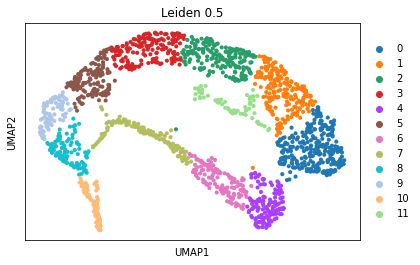

In [7]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

## Determining patient fate using a ConnectivityKernel

### Connectivity Kernels and stream embeddings

Depending on the data it may not always be possible to clearly define a cluster or specific patients as the origin. When working with single-cell data this is easier because when stem cells are detected these are usually the origin of cell differentiation processes.

In our case we do not have any clear origin and will therefore start with [cellrank's ConnectivityKernel](https://cellrank.readthedocs.io/en/stable/classes.html#connectivity-kernel). This kernel computes transition probabilities based on similarities among patients using a KNN graph.

First we define the kernel, compute the transition matrix and a projection ontop of the UMAP.

In [8]:
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()
ck.compute_projection(basis="umap")

Note that ConnectivityKernel has a `backward` parameter which can be set to `True` to compute everything backwards in time.

We can now visualize the project forwards and backwards in time using [scvelo](https://scvelo.readthedocs.io/).

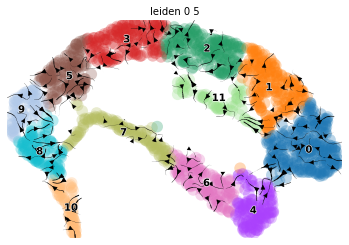

In [9]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

We observe that several clusters including e.g. 4 only really have outgoing arrows indicating steady states.

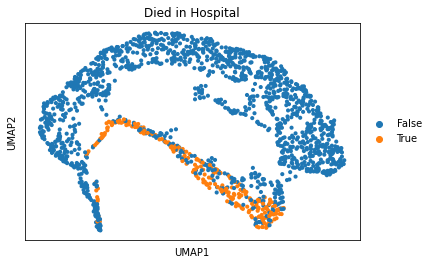

In [10]:
ep.pl.umap(adata, color="hosp_exp_flg", title="Died in Hospital")

Cluster 4 is apparently the cluster where most people died and clusters 6 and 7 further include many deceased patients.

Let's try to find the origins of the "death clusters". We will now define a [GPCCA](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.estimators.GPCCA.html) estimator to predict the patient fates using the above calculated transition matrix.

### Determining macrostates and terminal states

In [11]:
g = cr.tl.estimators.GPCCA(ck)

As a first step we try to identify macrostates in the data.

In [12]:
g.compute_macrostates(n_states=10, cluster_key="leiden_0_5")

In [13]:
g.macrostates_memberships

Lineage([[0.00897845, 0.02594726, 0.41826885, ..., 0.08669993,
          0.00323561, 0.01977123],
         [0.0014046 , 0.05673195, 0.03744207, ..., 0.02052313,
          0.37518492, 0.1473765 ],
         [0.00069993, 0.03546348, 0.03260979, ..., 0.33884664,
          0.00473829, 0.03467936],
         ...,
         [0.00494426, 0.03591037, 0.02880244, ..., 0.07994585,
          0.06079789, 0.02743981],
         [0.00442798, 0.03784252, 0.03116593, ..., 0.07666159,
          0.06678771, 0.08245835],
         [0.04702742, 0.41033996, 0.04742817, ..., 0.07799263,
          0.0479612 , 0.01160213]],
  names([10, 8, 7, 6, 9, 4, 5, 3, 1, 0]))

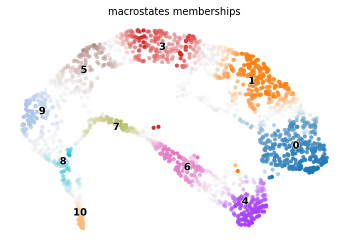

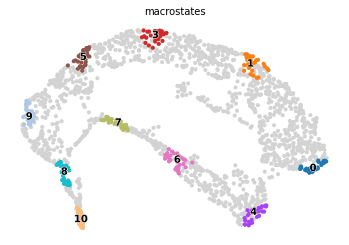

In [14]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

When calculating 10 macrostates we notice that 4, 6 and 7 have clear macrostates.

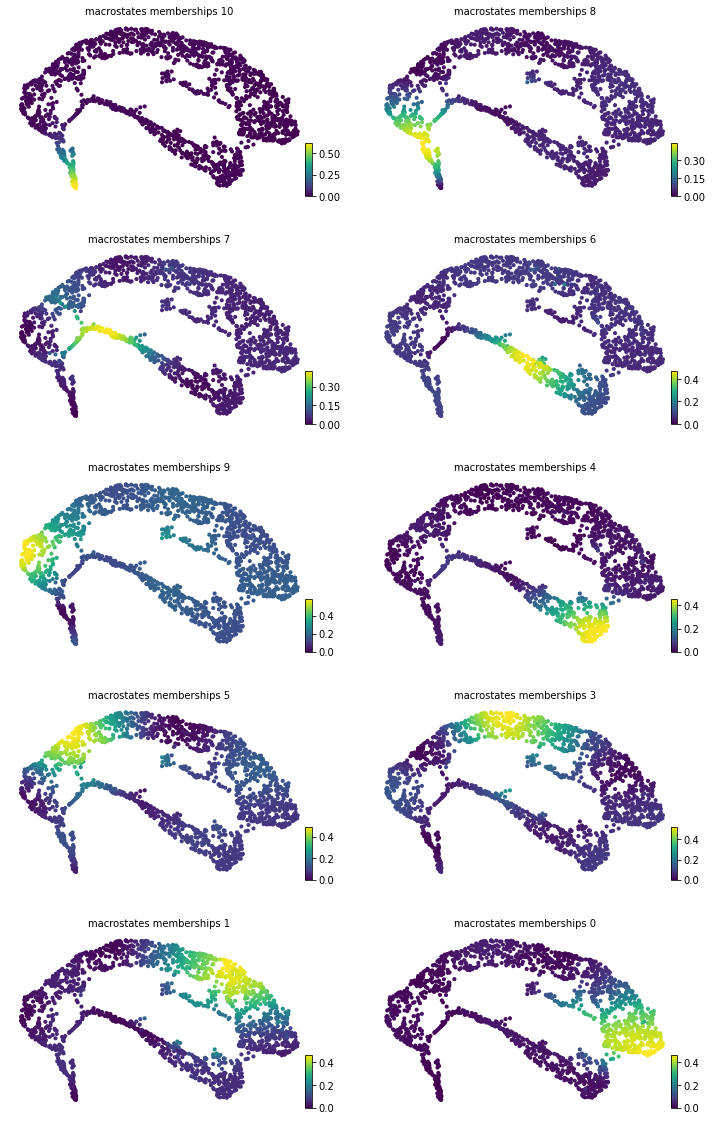

In [15]:
g.plot_macrostates(same_plot=False, ncols=2)

We will now define the macrostates 2, 7 and 8 as our terminal states.

In [16]:
g.set_terminal_states_from_macrostates(["4", "6", "7"])

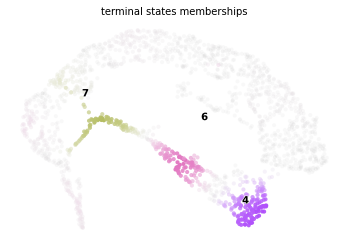

In [17]:
g.plot_terminal_states()

### Calculating absorption probabilities

As a next step we will calculate the [absorption probabilities](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.estimators.GPCCA.compute_absorption_probabilities.html#cellrank.tl.estimators.GPCCA.compute_absorption_probabilities). 

For each visit, this computes the probability of being absorbed in any of the terminal_states. In particular, this corresponds to the probability that a random walk initialized in transient visit will reach any visit from a fixed transient state before reaching a visit from any other transient state.

In [18]:
g.compute_absorption_probabilities()

Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

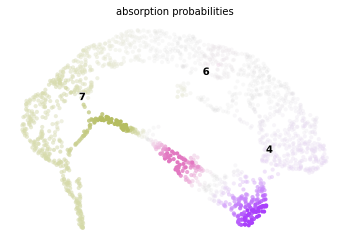

In [19]:
g.plot_absorption_probabilities()

We can also calculate a pseudotime which is required for all patient visits to reach these states.

In [20]:
g.compute_absorption_probabilities(time_to_absorption="all")
g.absorption_times

  0%|          | 0/3 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?/s]

4, 6, 7 mean
0         0.000000
1       675.029175
2       791.217346
3         0.000000
4       776.675598
...            ...
1771     89.029831
1772    147.434616
1773     99.896515
1774    209.609436
1775    923.022339

[1776 rows x 1 columns]

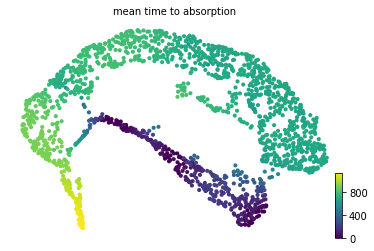

In [21]:
adata.obs["mean_time_to_absorption"] = g.absorption_times["4, 6, 7 mean"]
scv.pl.scatter(adata, color="mean_time_to_absorption")

As a next step we want to determine the major features driving these transitions and terminal states.

### Extracting lineage drivers

In [22]:
g.compute_lineage_drivers()

4_corr         4_pval  4_qval  4_ci_low  \
age                       0.205944   1.399184e-18     NaN  0.160972   
ehrapycat_day_28_flg      0.177633   4.037736e-14     NaN  0.132211   
bun_first                 0.161953   5.988487e-12     NaN  0.116315   
ehrapycat_chf_flg         0.159175   1.381294e-11     NaN  0.113502   
ehrapycat_hosp_exp_flg    0.154613   5.275975e-11     NaN  0.108883   
hour_icu_intime           0.139405   3.454737e-09     NaN  0.093497   
tco2_first                0.121351   2.820650e-07     NaN  0.075263   
ehrapycat_copd_flg        0.119604   4.183708e-07     NaN  0.073500   
ehrapycat_icu_exp_flg     0.118600   5.234307e-07     NaN  0.072487   
ehrapycat_afib_flg        0.117442   6.763006e-07     NaN  0.071318   
ehrapycat_resp_flg        0.113454   1.603671e-06     NaN  0.067295   
creatinine_first          0.083331   4.364980e-04     NaN  0.036961   
pco2_first                0.082915   4.663971e-04     NaN  0.036543   
potassium_first           0.082009   5.383498e-04     NaN  0.035631   
ehrapycat_stroke_flg      0.079407   8.061997e-04     NaN  0.033016   
ehrapycat_renal_flg       0.054974   2.049687e-02     NaN  0.008482   
ehrapycat_cad_flg         0.038714   1.029028e-01     NaN -0.007814   
icu_los_day               0.035428   1.356018e-01     NaN -0.011104   
ehrapycat_mal_flg         0.029466   2.145809e-01     NaN -0.017071   
bmi                       0.024930   2.937528e-01     NaN -0.021609   
sapsi_first               0.021750   3.596749e-01     NaN -0.024788   
platelet_first            0.019032   4.228572e-01     NaN -0.027506   
temp_1st                  0.018424   4.378259e-01     NaN -0.028114   
ehrapycat_day_icu_intime  0.011617   6.247217e-01     NaN -0.034916   
hospital_los_day          0.009078   7.022662e-01     NaN -0.037451   
sofa_first                0.006100   7.972886e-01     NaN -0.040425   
day_icu_intime_num        0.003127   8.952480e-01     NaN -0.043393   
map_1st                  -0.002198   9.262697e-01     NaN -0.048706   
abg_count                -0.005748   8.087508e-01     NaN -0.052248   
sodium_first             -0.011737   6.211449e-01     NaN -0.058219   
weight_first             -0.029469   2.145308e-01     NaN -0.075878   
ehrapycat_liver_flg      -0.031452   1.852412e-01     NaN -0.077852   
hgb_first                -0.056964   1.634198e-02     NaN -0.103204   
hr_1st                   -0.058101   1.431653e-02     NaN -0.104333   
chloride_first           -0.064345   6.665031e-03     NaN -0.110528   
ehrapycat_aline_flg      -0.065817   5.514064e-03     NaN -0.111988   
wbc_first                -0.072945   2.091168e-03     NaN -0.119055   
spo2_1st                 -0.085340   3.155472e-04     NaN -0.131333   
ehrapycat_gender_num     -0.089053   1.701006e-04     NaN -0.135008   
po2_first                -0.091870   1.047528e-04     NaN -0.137795   
ehrapycat_service_unit   -0.109619   3.580770e-06     NaN -0.155340   
ehrapycat_service_num    -0.131498   2.558758e-08     NaN -0.176929   
mort_day_censored        -0.171076   3.463457e-13     NaN -0.215872   
ehrapycat_censor_flg     -0.190598   4.478030e-16     NaN -0.235028   
iv_day_1                 -0.658322  1.559022e-242     NaN -0.683895   
sepsis_flg                     NaN            NaN     NaN       NaN   

                          4_ci_high    6_corr        6_pval  6_qval  6_ci_low  \
age                        0.250062  0.107811  5.181652e-06     NaN  0.061606   
ehrapycat_day_28_flg       0.222310  0.060133  1.124176e-02     NaN  0.013658   
bun_first                  0.206908 -0.015907  5.029515e-01     NaN -0.062374   
ehrapycat_chf_flg          0.204177  0.039414  9.681747e-02     NaN -0.007112   
ehrapycat_hosp_exp_flg     0.199691  0.050973  3.169896e-02     NaN  0.004470   
hour_icu_intime            0.184721  0.161297  7.305229e-12     NaN  0.115651   
tco2_first                 0.166923  0.040442  8.841130e-02     NaN -0.006083   
ehrapycat_copd_flg         0.165199  0.010

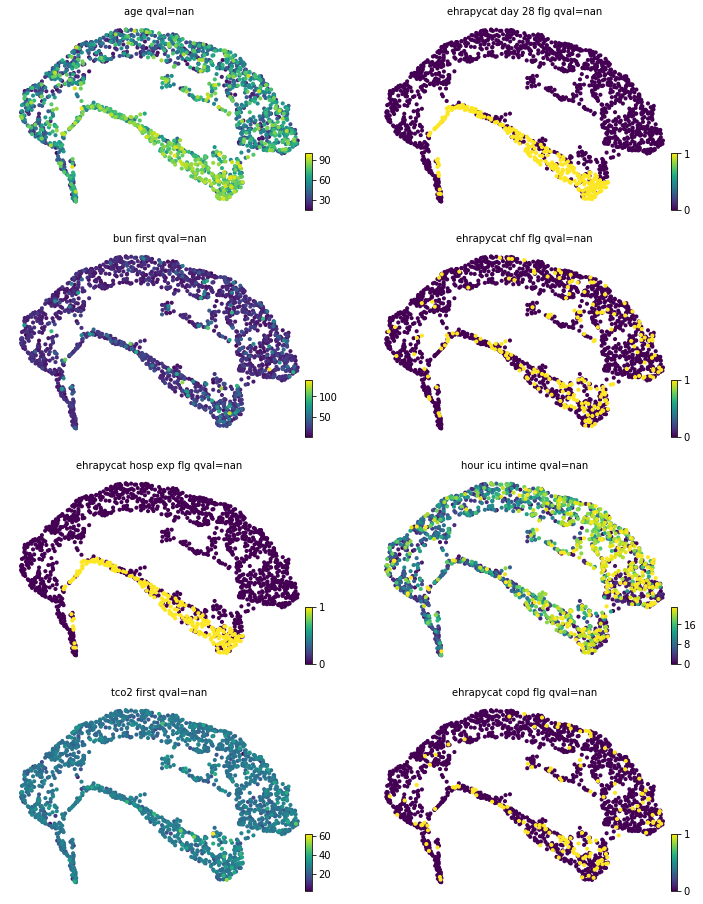

In [23]:
g.plot_lineage_drivers(lineage="4", ncols=2)

Cluster 4 seems to have a lot of patients with COPD as a comorbidities, old people and people with a high TCO2 concentration. 

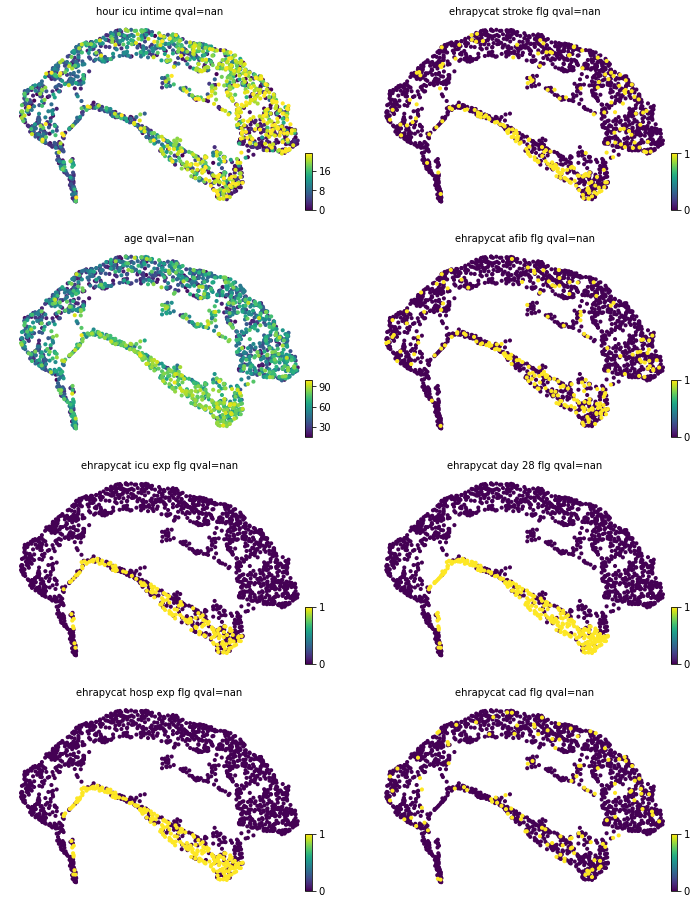

In [24]:
g.plot_lineage_drivers(lineage="6", ncols=2)

Cluster 6 is primarily influenced by atrial fibrillation (afib) and strokes as comoborbidities.

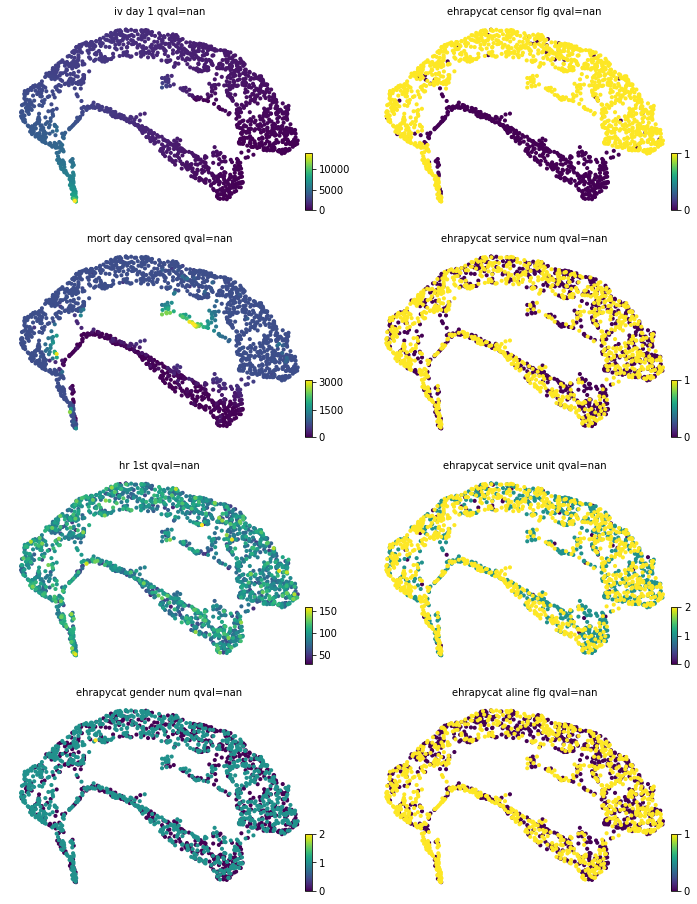

In [25]:
g.plot_lineage_drivers(lineage="7", ncols=2)

Cluster 7 is primarly defined as a terminal state by the heart rate (hr) and the IV input fluids (iv).

Although some of the features (e.g. congestive heart failure and age) overlap as drivers for death as a terminal state, all three clusters have unique origins of their macrostates.

We can also easily examine how likely it is that patients from a specific cluster end up in one of our three death dominated clusters.

### Exploring cluster fates

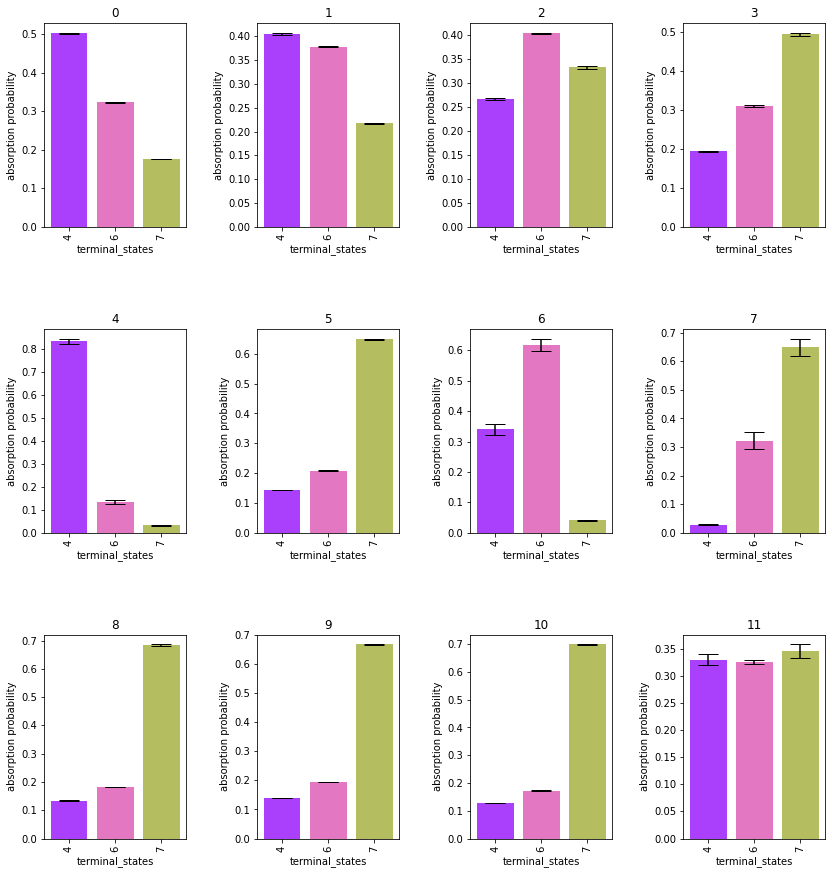

In [26]:
cr.pl.cluster_fates(adata, mode="bar", cluster_key="leiden_0_5")

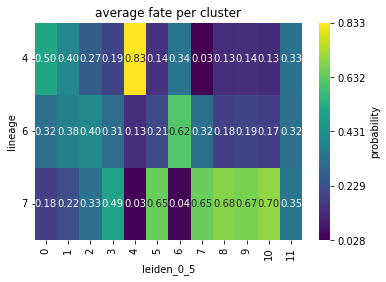

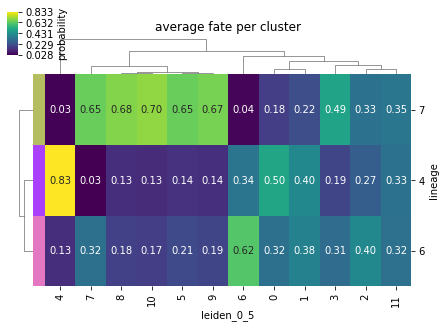

In [27]:
cr.pl.cluster_fates(adata, mode="heatmap", cluster_key="leiden_0_5")
cr.pl.cluster_fates(adata, mode="clustermap", cluster_key="leiden_0_5")

We can also leverage PAGA to visualize this information in a PAGA graph.

In [28]:
ep.tl.paga(adata, groups="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


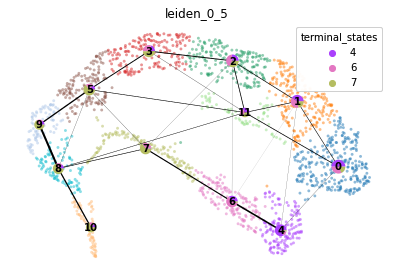

In [29]:
cr.pl.cluster_fates(adata, mode="paga_pie", basis="umap", cluster_key="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


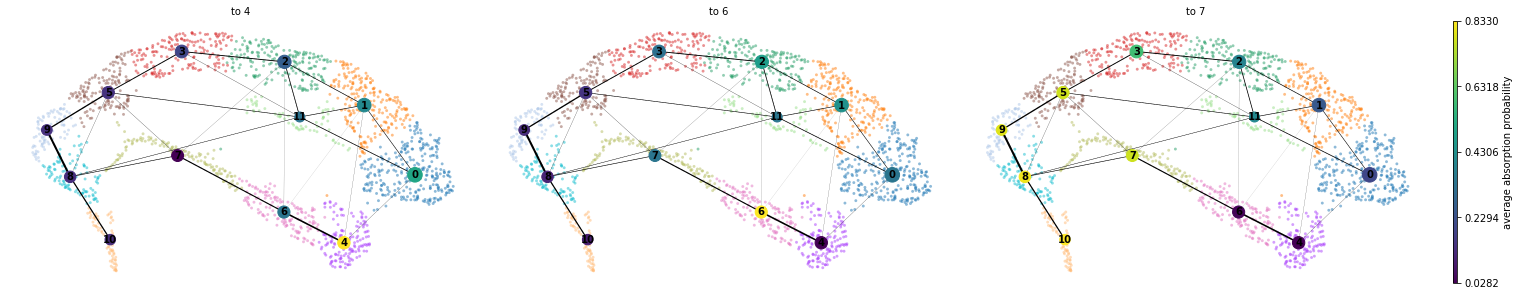

In [30]:
cr.pl.cluster_fates(
    adata, mode="paga", legend_loc="on data", basis="umap", cluster_key="leiden_0_5"
)

Finally, we can use a [circular projection](https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_circular_embedding.html) to represent the same information.

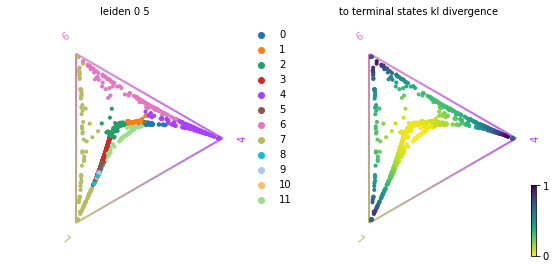

In [31]:
cr.pl.circular_projection(
    adata, keys=["leiden_0_5", "kl_divergence"], legend_loc="upper right"
)

## Determining patient fate with a PseudotimeKernel

We have now learnt that for example death dominated cluster 7 origins from cluster 10 (high IV).
Hence, we will now set a patient from cluster 10 as our root for our pseudotime calculation and will verify that we would indeed end up in clusters 4, 7 and 8.

Using pseudotime to find terminal states is even more useful when the terminal states are unknown and only a root cluster is clear.

In [32]:
adata = ep.dt.mimic_2(encoded=True)
ep.pp.knn_impute(adata)
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

Output()

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

Quality control metrics missing. Calculating...

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for faster imputations.

Output()

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:111: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/ipywidgets/widgets/widget_output.py:112: 
DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  self.msg_id = ip.kernel._parent_header['header']['msg_id']

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/home/zeth/

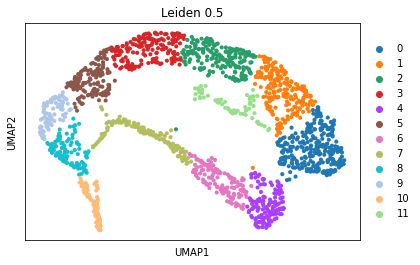

In [33]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

### Pseudotime Kernels and stream embeddings

The Pseudotime kernel computes direct transition probabilities based on a KNN graph and pseudotime.

The KNN graph contains information about the (undirected) connectivities among cells, reflecting their similarity. Pseudotime can be used to either remove edges that point against the direction of increasing pseudotime, or to downweight them.

In [34]:
adata.uns["iroot"] = np.flatnonzero(adata.obs["leiden_0_5"] == "10")[0]
ep.tl.dpt(adata)

In [35]:
pk = PseudotimeKernel(adata)
pk.compute_transition_matrix()
pk.compute_projection(basis="umap")

  0%|          | 0/1776 [00:00<?, ?cell/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/cellrank/tl/_utils.py:719: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(c) if issparse(c) else nx.from_numpy_array(c)


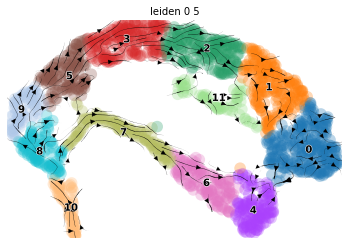

In [36]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

Now the arrows are much more clear and point into the direction of clusters 4, 6 and 7 from cluster 10.

### Simulating transitions with random walks

Cellrank makes it easy to simulate the behavior of random walks from specific clusters.
This allows us to not only visualize where the patients end up, but also roughly how many in which clusters after a defined number of iterations.
We can either just start walking...

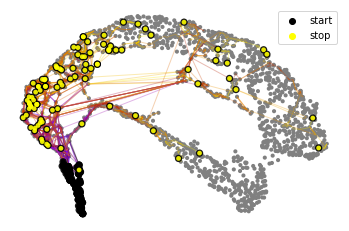

In [37]:
pk.plot_random_walks(
    100,
    start_ixs={"leiden_0_5": "10"},
    max_iter=100,
    show_progress_bar=False,
    ixs_legend_loc="best",
    seed=42,
)

... or set a number of required hits in one or more terminal clusters.
Here, we require 50 hits in one of our three "death" clusters.

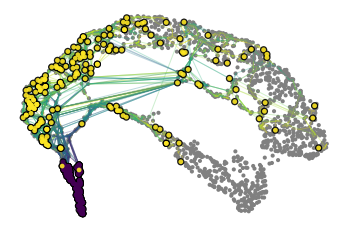

In [38]:
pk.plot_random_walks(
    200,
    start_ixs={"leiden_0_5": "10"},
    stop_ixs={"leiden_0_5": ["4", "6", "7"]},
    max_iter=100,
    successive_hits=50,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

### Determining macrostates and terminal states

Similarly to above when using our ConnectivityKernel we can compute macrostate memberships.

In [39]:
g = cr.tl.estimators.GPCCA(pk)
g.compute_schur()
g.compute_macrostates(cluster_key="leiden_0_5")
g.macrostates_memberships

Lineage([[0.0634495575, 0.9365504425],
         [0.5205536215, 0.4794463785],
         [0.565348831 , 0.434651169 ],
         ...,
         [0.0502122719, 0.9497877281],
         [0.1081423987, 0.8918576013],
         [0.8113031701, 0.1886968299]],
  names([10, 4]))

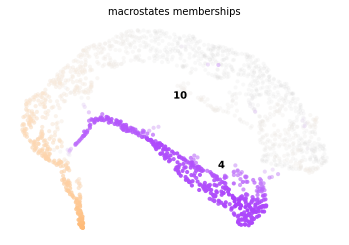

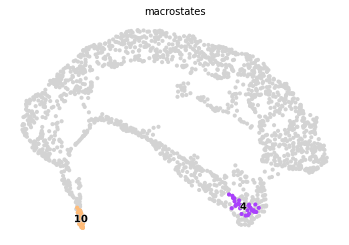

In [40]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

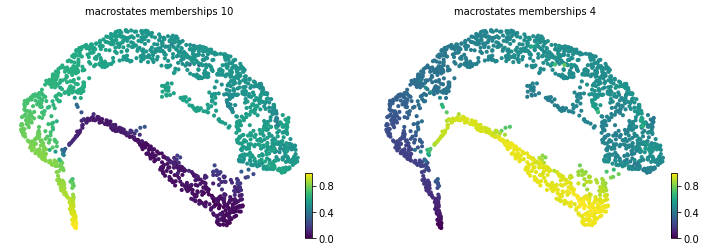

In [41]:
g.plot_macrostates(same_plot=False)

As expected cluster 4 is a macrostate. Furthermore, cluster 10 is apparently a macrostates.
This can likely be attributed to the fact that the people in cluster 10 are IV+.

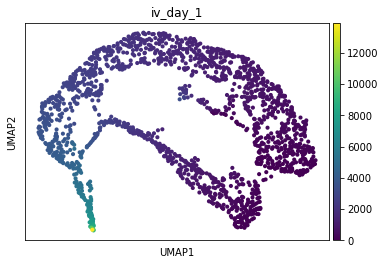

In [42]:
ep.pl.umap(adata, color="iv_day_1")

## Calculating absorption probabilities

Analogously we can compute terminal states, the absorption probabilities and the absorption times.

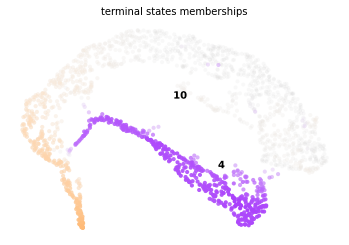

In [43]:
g.compute_terminal_states()
g.plot_terminal_states()

  0%|          | 0/2 [00:00<?, ?/s]

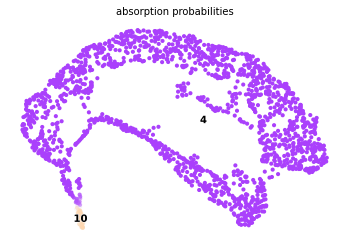

In [44]:
g.compute_absorption_probabilities(preconditioner="ilu", tol=1e-15)
g.plot_absorption_probabilities()

In [45]:
g.compute_absorption_probabilities(
    time_to_absorption="all", preconditioner="ilu", tol=1e-15
)
g.absorption_times

  0%|          | 0/2 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?/s]

10, 4 mean
0     356.025513
1     557.952515
2     606.034241
3     267.984680
4     625.649780
...          ...
1771  198.335678
1772  175.331970
1773  192.040298
1774  242.341309
1775  709.545837

[1776 rows x 1 columns]

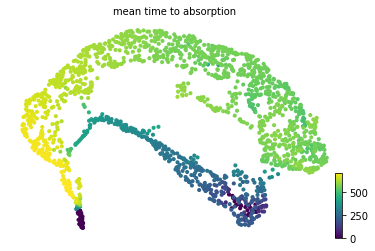

In [46]:
adata.obs["mean_time_to_absorption"] = g.absorption_times["10, 4 mean"]
scv.pl.scatter(adata, color="mean_time_to_absorption")

## Extracting lineage drivers

Furthermore, just like above we can visualize the lineage drivers.

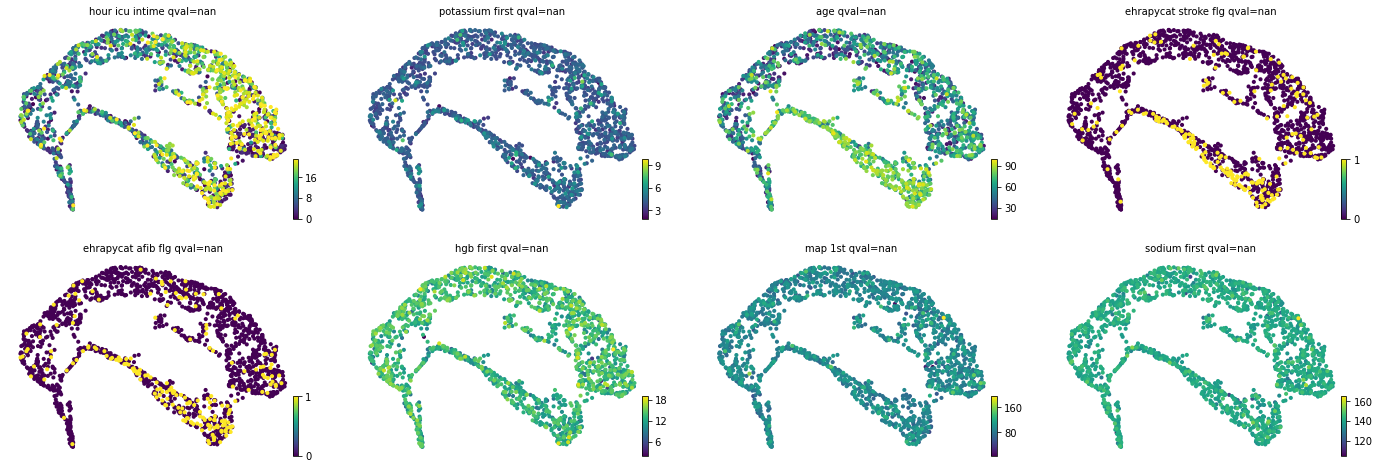

In [47]:
g.compute_lineage_drivers()
g.plot_lineage_drivers(lineage="4")

The primary lineage drivers for cluster 4 are for example age and high potassium values.

### Determining feature trends

cellrank uses [Generalized Additive Models (GAMs)](https://cellrank.readthedocs.io/en/latest/api/cellrank.ul.models.GAM.html) to determine trends of features.

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

did not converge


/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

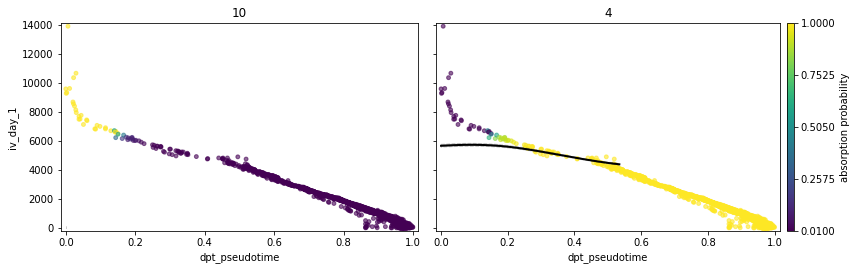

In [48]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

did not converge


/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

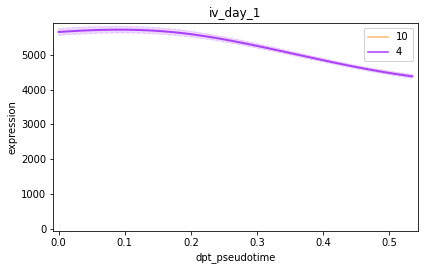

In [49]:
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    same_plot=True,
    hide_cells=True,
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)